# Compute optimal portfolio and compare to real data

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import numpy as np

from src.utils import Utils

In [2]:
tickers_path = "data/tickers.json"
returns_path = "data/returns.csv"
volatilities_path = "data/volatilities.csv"
correlations_path = "data/correlations.csv"

In [3]:
tickers = Utils.load_SP500_list(path=tickers_path)
tickers.remove("AMTM")
returns = Utils.load_returns_list(path=returns_path)
volatilities = Utils.load_volatilities_list(path=volatilities_path)
correlations = Utils.load_correlations_list\
    (path=correlations_path, tickers=tickers)

In [4]:
ret_vec = np.array([returns[ticker] for ticker in tickers])
vol_vec = np.array([volatilities[ticker] for ticker in tickers])
corr_mat = np.array([[correlations[(Utils.make_ordered_pair(a, b))] \
    if a != b else np.float64(0) for a in tickers] for b in tickers])
np.fill_diagonal(corr_mat, 1)
cov_mat = np.outer(vol_vec, vol_vec) * corr_mat

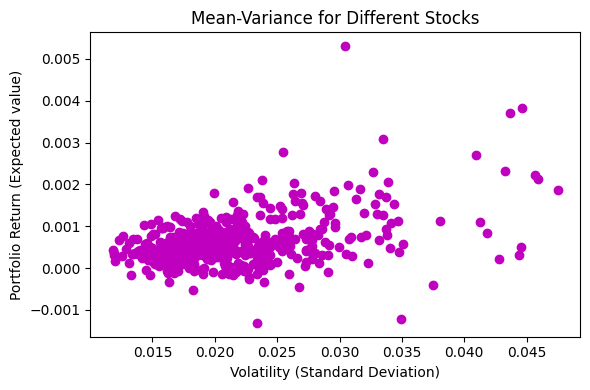

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(vol_vec, ret_vec, "mo")
plt.title("Mean-Variance for Different Stocks")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Portfolio Return (Expected value)")
plt.tight_layout()
plt.show()

In [6]:
J_list = [2, 3, 5, 7, 20, 40, 100, 200, 500]
mu_w_list = np.arange(-0.025, 0.025, 0.0001)
w_list = {}
std_w_list = {}

for J in J_list:

    l1 = []
    l2 = []

    for mu_w in mu_w_list:

        w, std_w = Utils.get_opt_sol\
            (J=J, mu_w=mu_w, ret_vec=ret_vec, cov_mat=cov_mat)
        l1.append(w)
        l2.append(std_w)

    w_list[J] = l1
    std_w_list[J] = l2

max_sharpes = {J: (mu_w_list / std_w_list[J]).max() for J in J_list}
max_sharpe_indices = {J: int((mu_w_list / std_w_list[J]).argmax()) \
    for J in J_list}
best_portfolios = {J: w_list[J][max_sharpe_indices[J]] for J in J_list}

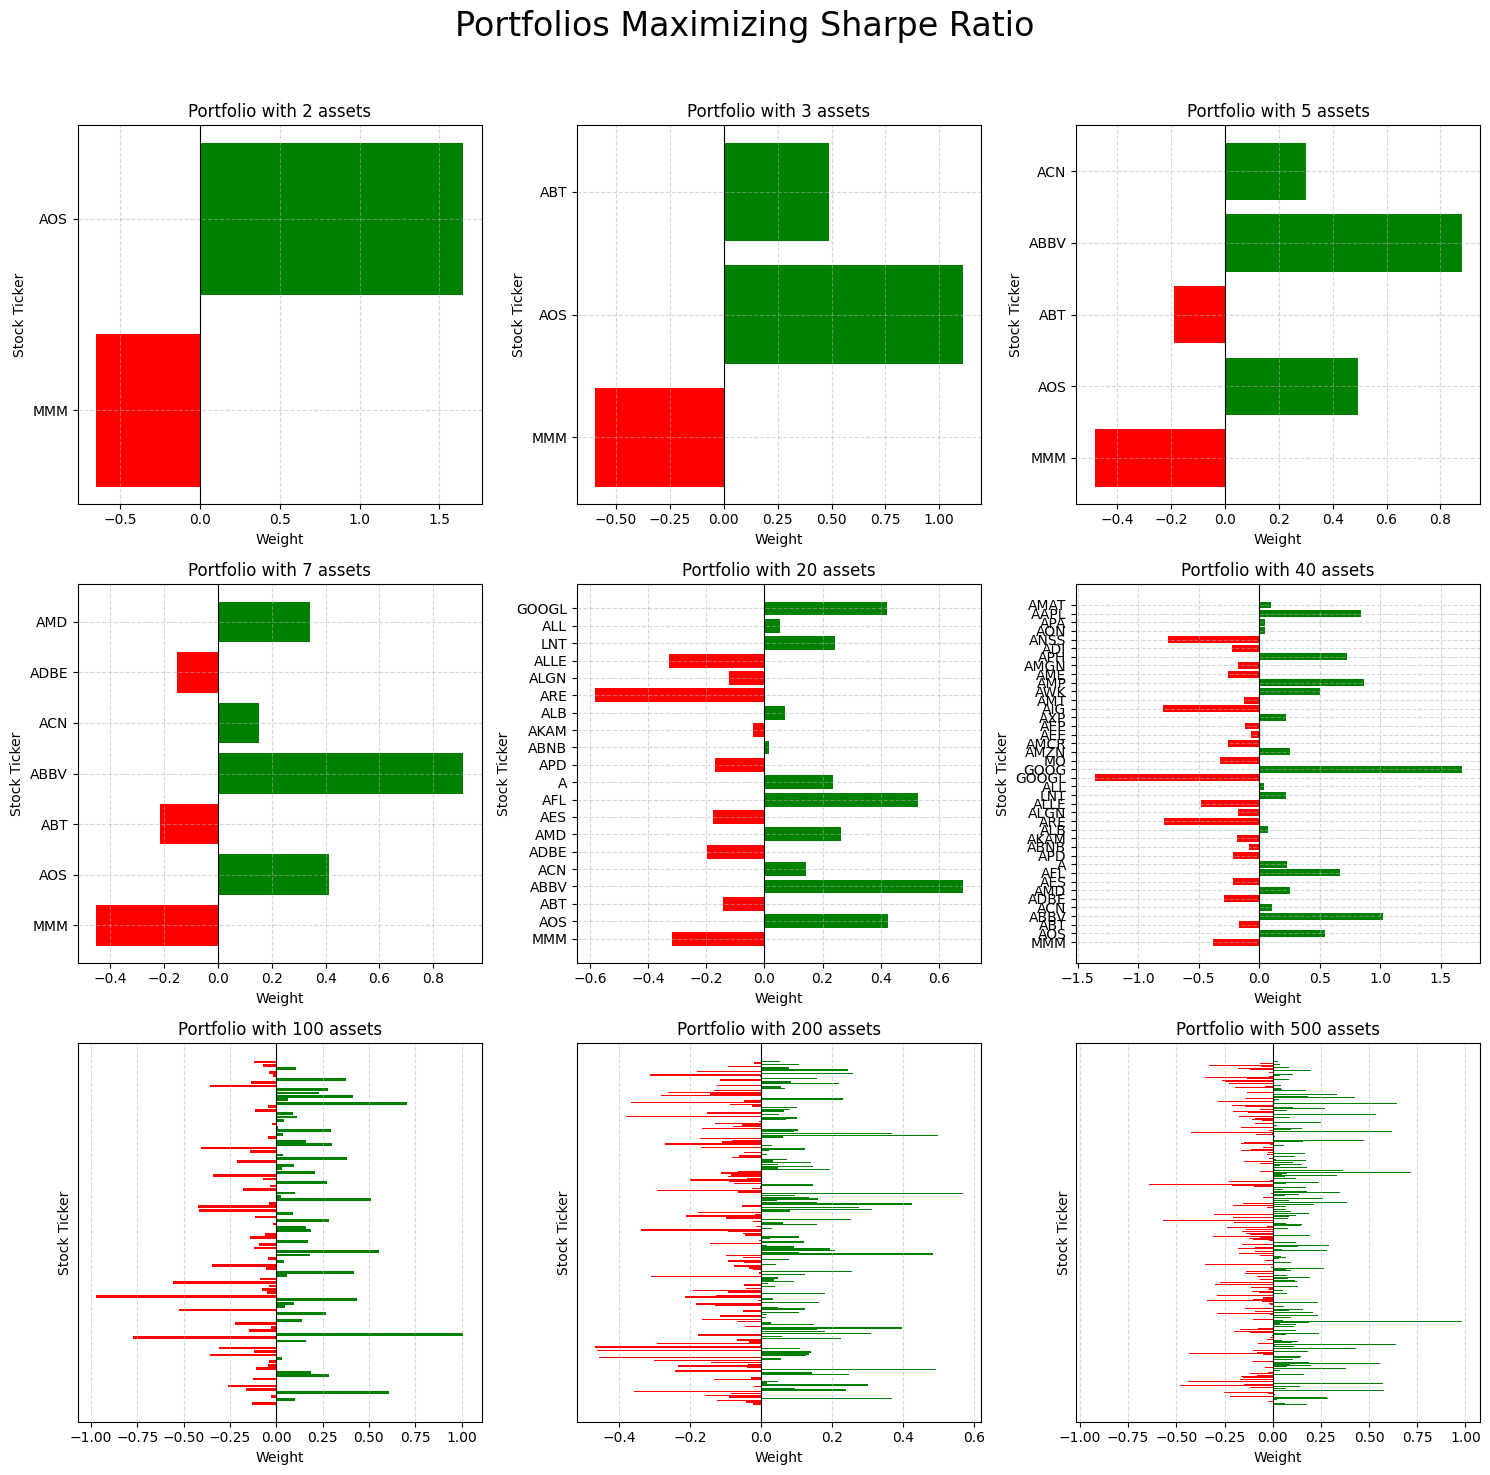

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Portfolios Maximizing Sharpe Ratio", fontsize=24)

for idx, J in enumerate(J_list):

    ax = axes[idx // 3, idx % 3]
    bars = ax.barh(tickers[:len(best_portfolios[J])], best_portfolios[J], \
        color=['green' if w > 0 else 'red' for w in best_portfolios[J]])
    
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Stock Ticker")
    ax.set_title(f"Portfolio with {J} assets")
    if J >= 100:
        ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

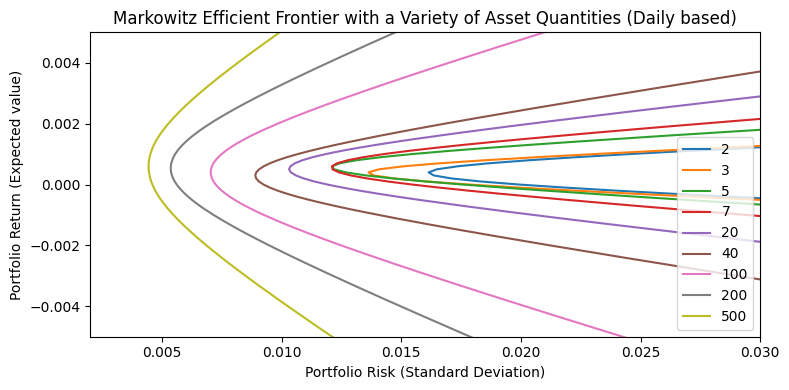

In [8]:
plt.figure(figsize=(8, 4))

for J in J_list:

    plt.plot(std_w_list[J], mu_w_list, label=f"{J}")

plt.title("Markowitz Efficient Frontier with a Variety of Asset Quantities (Daily based)")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return (Expected value)")
plt.xlim(0.002, 0.03)
plt.ylim(-0.005, 0.005)
plt.legend()
plt.tight_layout()
plt.show()

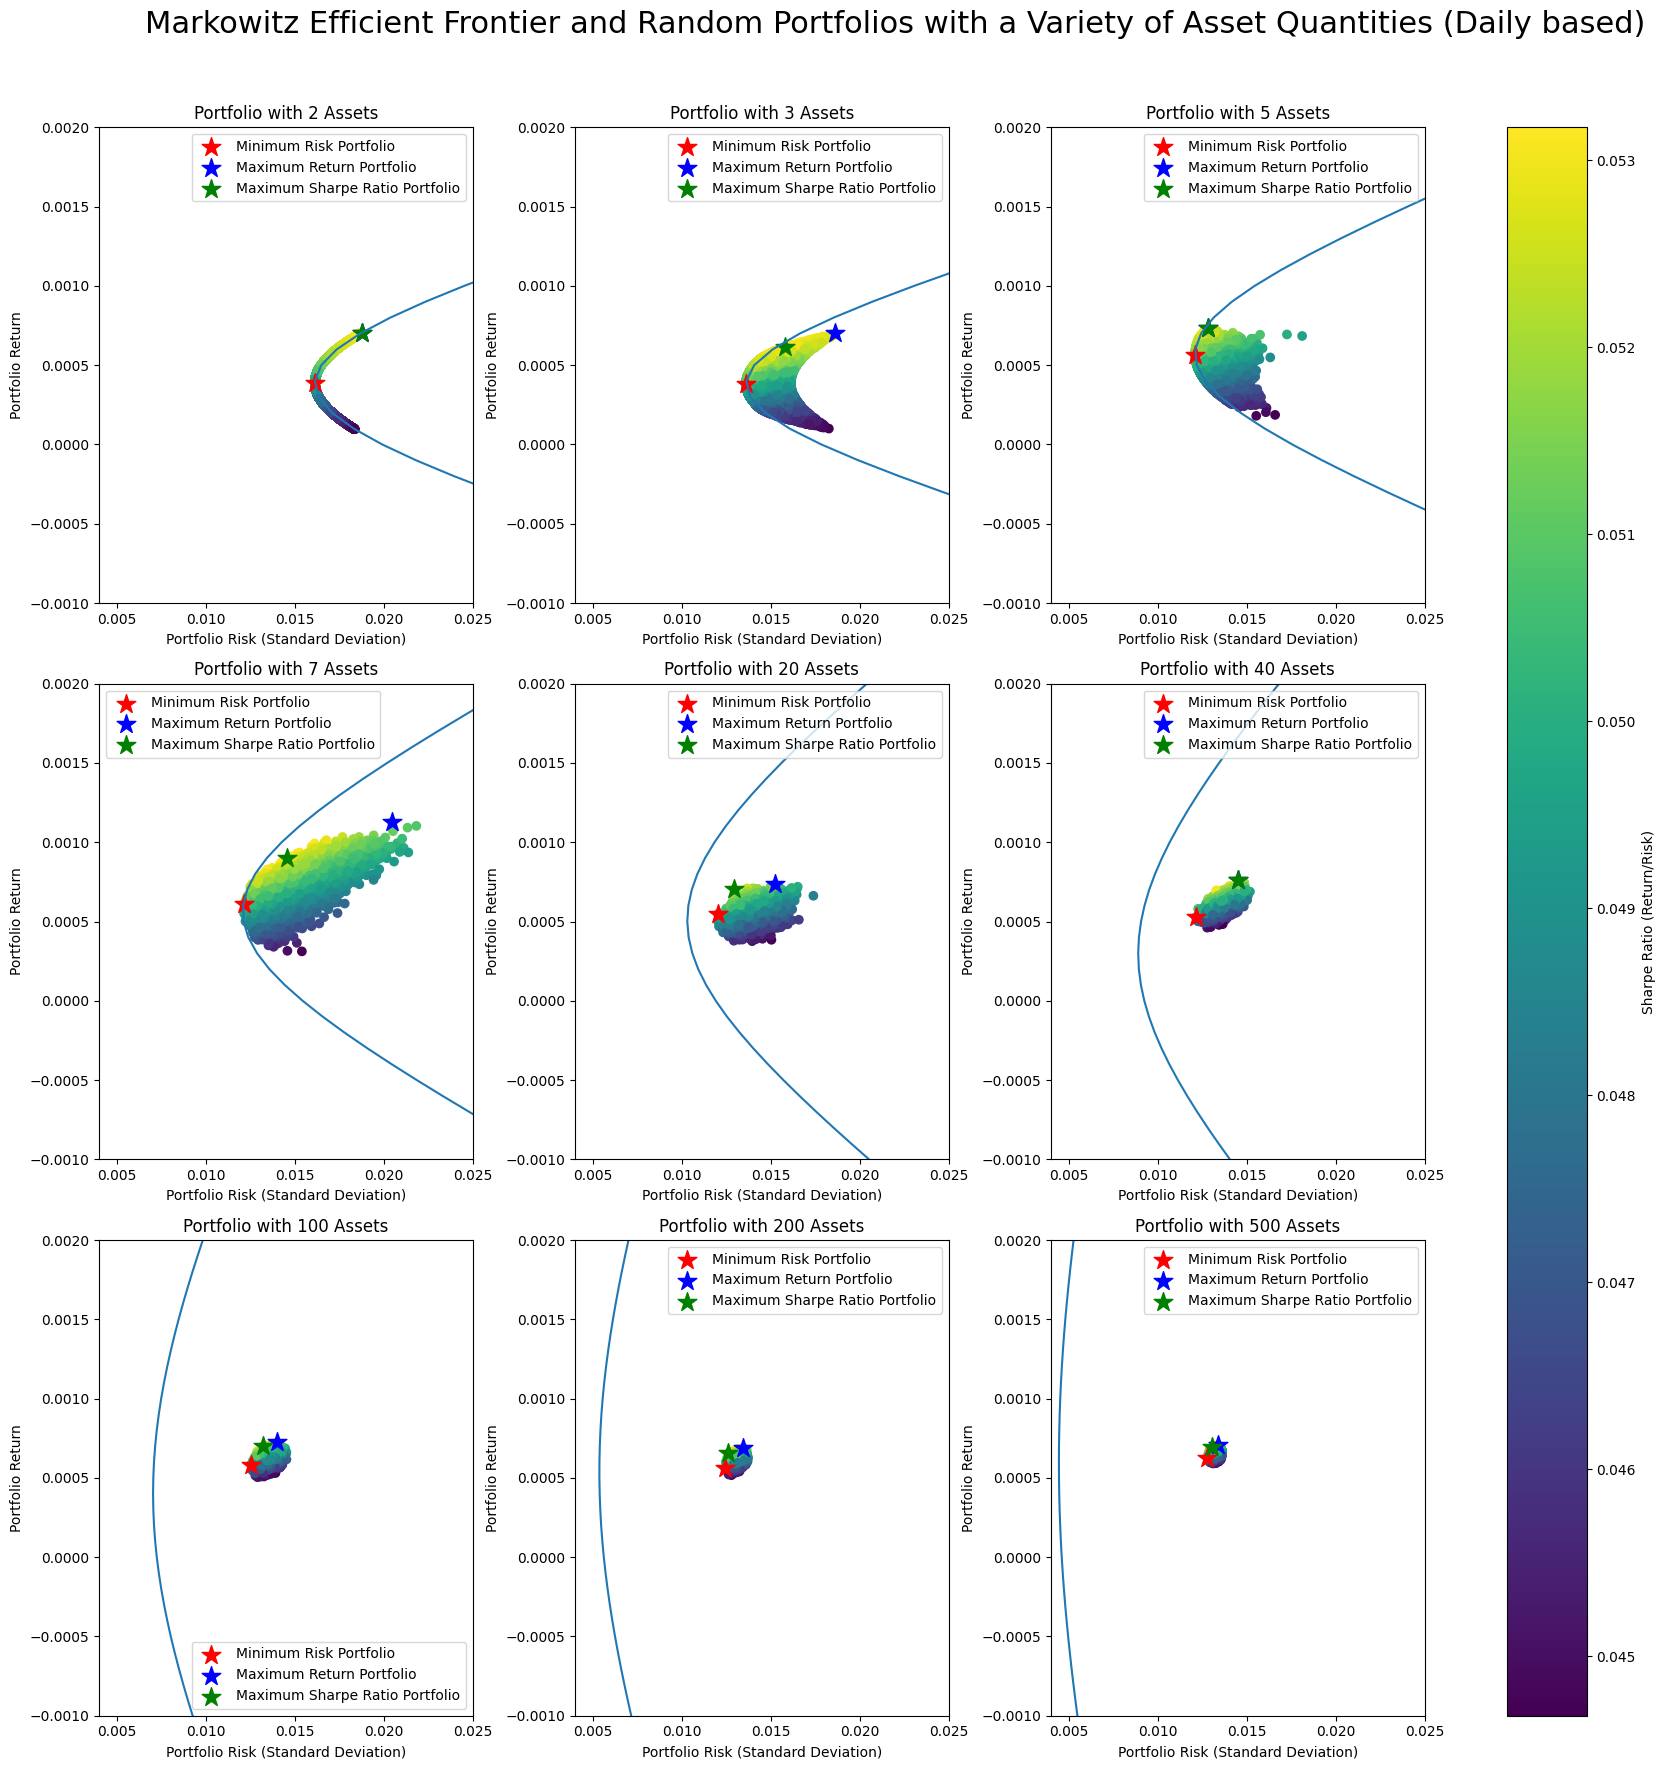

In [9]:
num_portfolios = 30000
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for idx, J in enumerate(J_list):

    row = idx // 3
    col = idx % 3

    random_portfolios = np.zeros((2, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.random(J)
        weights /= np.sum(weights)
        mu = ret_vec[:J] @ weights
        sigma = np.sqrt(weights.T @ cov_mat[:J, :J] @ weights)
        random_portfolios[0, i] = mu
        random_portfolios[1, i] = sigma

    ax = axes[row, col]
    sc = ax.scatter(random_portfolios[1], random_portfolios[0], 
                    c=random_portfolios[0]/random_portfolios[1], \
                        cmap='viridis', marker='o')

    min_volatility = random_portfolios[1].min()
    min_volatility_idx = random_portfolios[1].argmin()
    ax.scatter(\
        random_portfolios[1][min_volatility_idx], \
            random_portfolios[0][min_volatility_idx], \
        marker='*', color='red', s=200, label="Minimum Risk Portfolio")

    max_return = random_portfolios[0].max()
    max_return_idx = random_portfolios[0].argmax()
    ax.scatter(\
        random_portfolios[1][max_return_idx], \
            random_portfolios[0][max_return_idx], \
        marker='*', color='blue', s=200, label="Maximum Return Portfolio")

    max_sharpe_ratio = (random_portfolios[0]/random_portfolios[1]).max()
    max_shapre_ratio_idx = (random_portfolios[0]/random_portfolios[1]).argmax()
    ax.scatter(\
        random_portfolios[1][max_shapre_ratio_idx], \
            random_portfolios[0][max_shapre_ratio_idx], \
        marker='*', color='green', s=200, label="Maximum Sharpe Ratio Portfolio")

    px = []
    py = []
    for mu_w in np.arange(-0.005, 0.005, 0.0001):
        w, std_w = Utils.get_opt_sol\
            (J=J, mu_w=mu_w, ret_vec=ret_vec, cov_mat=cov_mat)
        px.append(std_w)
        py.append(mu_w)
    ax.plot(px, py)

    ax.set_title(f'Portfolio with {J} Assets')
    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Portfolio Return')
    ax.set_xlim(0.004, 0.025)
    ax.set_ylim(-0.001, 0.002)
    ax.legend()

plt.suptitle('Markowitz Efficient Frontier and Random Portfolios with a Variety of Asset Quantities (Daily based)', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.colorbar(sc, ax=axes, label='Sharpe Ratio (Return/Risk)')
plt.show()